# MLP with sentence level embedding

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import torch.nn.functional as F

In [2]:
papers = pd.read_csv("data/sci_papers.csv")

In [3]:
df = papers
counts = df["category"].value_counts()
categories = df.category.unique()
others = counts.index[5:].tolist()
df.loc[df['category'].isin(others), 'category'] = 'others'


In [4]:
titles = df["title"]

# Create a list of all unique words by splitting titles into words and using set
unique_words = set()
for title in titles:
    # Split each title into words and convert to lowercase
    words = ''.join(char.lower() for char in title if char.isalnum() or char.isspace()).split()
    unique_words.update(words)

# Convert set back to list for easier manipulation
vocab = sorted(list(unique_words))
len(vocab)

63800

Each word is embbeded with a emb_dim dimensional vector. 

The sentence is represented by a vector of size emb_dim, which is the coordonate by coordonate average of the word vectors.

The sentence vector is then passed to a MLP 


In [131]:
# each word is embbeded in a emb_dim dimension space
# So each title is embbeded as a list of word embeddings 
# As each title has a different length we will resort to pooling methods

categories = df.category.unique()

wtoi = {t:i for i,t in enumerate(vocab)} # word to integer 
itow = {i:t for i,t in enumerate(vocab)} # integer to word

ttoi = {t:i for i,t in enumerate(titles)} # title to integer 
itot = {i:t for i,t in enumerate(titles)} # integer to title

ctoi = {c:i for i,c in enumerate(categories)} # category to integer
itoc = {i:c for i,c in enumerate(categories)} # integer to category


In [35]:
emb_dim = 30
C = torch.randn((len(vocab), emb_dim))
C[0]

tensor([-0.6153,  0.5259, -0.8577, -0.8295, -0.7789, -0.7647,  0.9504,  0.6444,
        -2.1112,  0.6415,  0.8978, -2.2323, -0.3458,  0.7734, -1.8219,  0.0540,
         0.2682, -1.5159,  0.3070,  1.2846, -0.0076,  1.4525, -1.4885, -2.0725,
         1.3749,  1.0636,  3.3695,  0.3144, -0.8884, -0.6175])

In [ ]:

emb_titles = []
for t in titles:
    t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in t)
    words = t_clean.split()

    indices = [wtoi[w] for w in words if w in wtoi]
    word_embeddings = C[indices] # (nbr_words_in_title, emb_dim)
    avg_embedding = word_embeddings.mean(dim=0) # mean 
    
    emb_titles.append(avg_embedding)

emb_titles = torch.stack(emb_titles)
emb_titles.shape # (nbr_titles, emb_dim)

In [181]:
def titles_embbeding(titles, C, poolingtype="avg"): 
    titles_emb = []
    for t in titles:
        t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in t)
        words = t_clean.split()

        indices = [wtoi[w] for w in words if w in wtoi]
        word_embeddings = C[indices] # (nbr_words_in_title, emb_dim)
        if poolingtype == "avg":
            emb = word_embeddings.mean(dim=0) # mean 
        elif poolingtype == "max":
            emb = word_embeddings.max(dim=0)[0] # max values without the indices
        else:
            print("Choose between 'avg' and 'max'")
        titles_emb.append(emb)

    titles_emb = torch.stack(titles_emb)
    return titles_emb

batch_titles = [itot[i] for i in range(0,5)]
print(titles_embbeding(batch_titles, C, 'max'))

tensor([[ 1.3599,  1.8582, -0.6050,  1.4319, -0.8597,  0.3325,  1.6371,  1.6312,
          0.1389,  0.6891],
        [ 0.9025,  1.8972,  0.1991,  1.6099,  1.0642,  1.8732,  2.4548,  1.6520,
          1.5915,  1.0533],
        [ 2.8716,  2.4602,  0.1139,  1.6610,  1.8620,  1.5161,  0.7250,  1.9486,
          0.4092,  1.9306],
        [ 0.9904,  1.7022,  1.7307,  1.6610,  2.3768, -0.3382,  2.0953,  1.8125,
          0.4092,  1.1947],
        [ 1.6974,  0.9738,  0.9878,  1.6251,  2.4023,  1.1256,  0.9876,  3.0833,
          1.6390,  1.7303]], grad_fn=<StackBackward0>)


In [52]:
print(emb_titles[0])  # prints the embedding of the first title

t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in titles[0])
words = t_clean.split()
word_embeddings = torch.stack([C[wtoi[w]] for w in words])
print(word_embeddings)  # prints embeddings of each word in the first title
print(torch.mean(word_embeddings, dim=0))  # prints the mean embedding across all words$

# we see that the mean pooling works
# In this simple example (2 words) we see that the embedded title is the coordinate-wise mean of the embedded words

# Now, we can train an MLP with the input beeing a title embbeding 

tensor([-0.7358, -0.4954,  0.9357,  0.2470, -0.9818,  0.1556, -0.8622,  1.9042,
        -0.9372, -0.3247, -0.9486, -1.4173, -0.2634, -1.0253, -1.0854, -1.8456,
        -0.7672, -0.4807, -0.6087,  0.3431, -0.1922, -0.0295,  0.5408,  0.5881,
         0.4310,  1.2848,  1.2635, -0.1438, -0.6674, -0.0533])
tensor([[-0.5071, -1.6392,  0.6542,  0.2879, -1.0984,  0.4662, -0.6844,  0.5417,
         -0.3268, -0.8851, -0.8513, -0.9094, -0.1195,  0.1104, -0.9749, -1.1119,
         -1.3838,  0.2454, -1.3529,  0.2864,  0.4461,  0.8756,  1.3577,  1.5708,
          0.5058,  1.2058,  2.0327, -0.0757,  0.7134, -0.3757],
        [-0.9646,  0.6484,  1.2173,  0.2061, -0.8652, -0.1550, -1.0400,  3.2666,
         -1.5476,  0.2356, -1.0459, -1.9252, -0.4073, -2.1610, -1.1958, -2.5793,
         -0.1507, -1.2069,  0.1355,  0.3998, -0.8305, -0.9345, -0.2761, -0.3946,
          0.3562,  1.3638,  0.4942, -0.2119, -2.0482,  0.2692]])
tensor([-0.7358, -0.4954,  0.9357,  0.2470, -0.9818,  0.1556, -0.8622,  1.9042,
  

In [53]:

def build_dataset(papers):  
    X = torch.arange(0, papers.shape[0])
    Y = torch.tensor([ctoi[df["category"][i]] for i in range(0, papers.shape[0])])
    #print(X.shape, Y.shape)
    return X, Y

build_dataset(df[:10])

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [54]:
import random
random.seed(42)
indices = list(range(len(papers)))
random.shuffle(indices)
papers_shuffled = papers.iloc[indices].reset_index(drop=True) # shuffled dataset 
n1 = int(0.8*len(papers_shuffled))
n2 = int(0.9*len(papers_shuffled))
Xtr, Ytr = build_dataset(papers_shuffled[:n1])
Xdev, Ydev = build_dataset(papers_shuffled[n1:n2])
Xte, Yte = build_dataset(papers_shuffled[n2:])

In [195]:
nbr_added_layers = 1
nbr_neurons_hidden = [256 for _ in range(nbr_added_layers)]
nbr_neurons_first = 256
nbr_categories = len(categories)
nbr_titles = len(titles)
vocab_size = len(vocab)
emb_dim = 10

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim, nbr_neurons_first), generator=g) / nbr_neurons_first**0.5 # kaiming init
b1 = torch.randn(nbr_neurons_first, generator=g) * 0.1

Ws = []
bs = []
parameters = [C, W1, b1]
for i in range(0, nbr_added_layers):
    if i == 0:
        W = torch.randn((nbr_neurons_first, nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    else : 
        W = torch.randn((nbr_neurons_hidden[i], nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    
    b = torch.randn(nbr_neurons_hidden[i], generator=g) * 0.1
    parameters.append(W)
    parameters.append(b)
    Ws.append(W)
    bs.append(b)

Wlast = torch.randn((nbr_neurons_hidden[-1], nbr_categories), generator=g) / nbr_neurons_hidden[-1]**0.5
blast = torch.randn((nbr_categories), generator=g) * 0.1

parameters.append(Wlast)
parameters.append(blast)

for p in parameters:
    print(p.shape)

print(sum(p.nelement() for p in parameters))

torch.Size([63800, 10])
torch.Size([10, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 6])
torch.Size([6])
708150


In [196]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, lri = [], [], []

In [202]:
n = 500000
batch_size = 32
lre = torch.linspace(-3, 0, n)
lrs = 10**lre #from 0.001 to 1 exponentielly stepped 
pooling_type = "avg"

for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Get the titles for these indices
    batch_titles = [itot[i.item()] for i in ixs]
    
    # Calculate embeddings for these titles using average pooling
    emb = titles_embbeding(batch_titles, C, pooling_type)
    
    # Forward pass through the network
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Use modulo to cycle through learning rates
    #lr = lrs[i % len(lrs)]
    lr = 0.1 if i<0.9*n else 0.01
    #lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad 

    stepi.append(i)
    #lri.append(lr.item())
    lossi.append(loss.item())


In [203]:
def deep_model_test(X,Y):
    # Get the titles for these indices
    batch_titles = [itot[i.item()] for i in X]
    
    # Stack all embeddings into a single tensor
    emb = titles_embbeding(batch_titles, C, pooling_type)
    
    # Forward pass through the network
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Y) 


    return loss

ldev = deep_model_test(Xdev, Ydev)
ltest = deep_model_test(Xte, Yte)
ltrain = deep_model_test(Xtr, Ytr)
print("ltrain : ", ltrain)
print("dev : ", ldev)
print("test : ", ltest)

# with 60k iterations (avg_pooling, emb_dim = 10, 1 hidden layer, 256 neurons per layer)
#ltrain :  tensor(1.1399, grad_fn=<NllLossBackward0>)
#dev :  tensor(1.5250, grad_fn=<NllLossBackward0>)
#test :  tensor(1.5250, grad_fn=<NllLossBackward0>)
# and the loss isn't platauing 

# Same with max pooling : 
# ltrain : 1.1614
# dev :  1.7479
# test : 1.7479

ltrain :  tensor(0.6415, grad_fn=<NllLossBackward0>)
dev :  tensor(0.7594, grad_fn=<NllLossBackward0>)
test :  tensor(0.7594, grad_fn=<NllLossBackward0>)


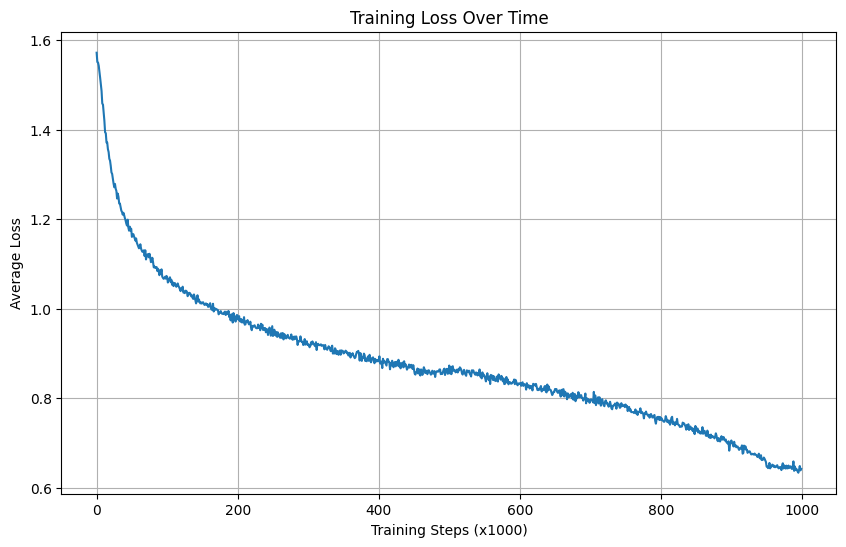

In [204]:
# Plot 1: Loss over training iterations (averaged over a window size)
window_size = 1000  # adjust this value to get smoother/rougher plot
plt.figure(figsize=(10, 6))
losses = torch.tensor(lossi)
n = len(losses)
n_windows = n // window_size
averaged_losses = losses[:n_windows * window_size].view(-1, window_size).mean(1)


plt.plot(torch.tensor(lossi).view(-1, window_size).mean(1))
plt.xlabel(f'Training Steps (x{window_size})')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Plot 2: Loss vs Learning Rate (averaged over 100 iterations)
# plt.figure()
# plt.plot(torch.tensor(lri).view(-1, 100).mean(1), torch.tensor(lossi).view(-1, 100).mean(1))
# plt.xlabel('Learning Rate')
# plt.ylabel('Average Loss')
# plt.title('Loss vs Learning Rate')
# plt.xscale('log')  # Learning rate is typically better viewed in log scale
# plt.grid(True)
# plt.show()

In [206]:
# forward
batch_titles = [itot[i.item()] for i in Xte]
emb = titles_embbeding(batch_titles, C, pooling_type)

x = torch.tanh(emb @ W1 + b1)  
for W, b in zip(Ws, bs): 
    x = torch.tanh(x @ W + b)
logits = x @ Wlast + blast
probs = F.softmax(logits, dim=1)

# Display last 5 results
print("5 papers predictions:")
indices = torch.randint(0, len(papers_shuffled.iloc[n2:]), (5,))
for idx in indices:
    print("\nTitle:", papers_shuffled.iloc[n2:].iloc[idx.item()]['title'])
    print("True category:", papers_shuffled.iloc[n2:].iloc[idx.item()]['category'])
    print("\nPredicted probabilities:")
    # Sort probabilities in descending order and get corresponding categories
    sorted_probs = [(prob.item(), cat) for prob, cat in zip(probs[idx.item()], categories)]
    sorted_probs.sort(reverse=True)
    for prob, cat in sorted_probs:
        print(f"{cat}: {prob*100:.2f}%")

5 papers predictions:

Title: A mathematical theory of semantic development in deep neural networks
True category: Machine Learning

Predicted probabilities:
Computation and Language (Natural Language Processing): 82.19%
Machine Learning: 15.61%
Machine Learning (Statistics): 0.85%
Artificial Intelligence: 0.75%
others: 0.44%
Computer Vision and Pattern Recognition: 0.16%

Title: Fuzzy Bayesian Learning
True category: Machine Learning (Statistics)

Predicted probabilities:
Machine Learning: 49.69%
others: 23.27%
Artificial Intelligence: 14.77%
Machine Learning (Statistics): 10.80%
Computer Vision and Pattern Recognition: 1.44%
Computation and Language (Natural Language Processing): 0.03%

Title: The Benefits of Being Categorical Distributional: Uncertainty-aware
  Regularized Exploration in Reinforcement Learning
True category: Machine Learning

Predicted probabilities:
Artificial Intelligence: 93.80%
Computation and Language (Natural Language Processing): 2.74%
others: 2.64%
Machine L

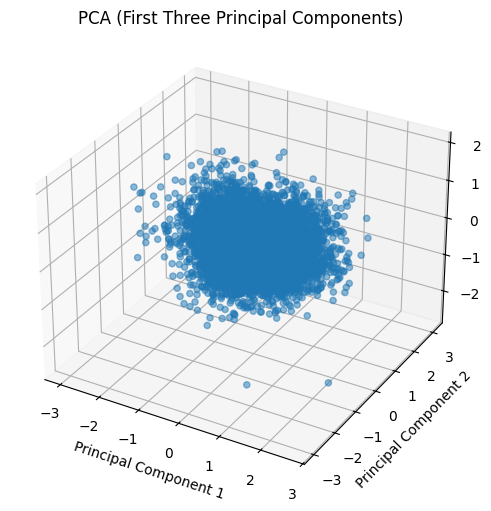

Composante 1: 20.43%
Composante 2: 12.87%
Composante 3: 12.31%
Composante 4: 9.31%
Composante 5: 8.97%
Composante 6: 8.08%
Composante 7: 7.88%
Composante 8: 7.11%
Composante 9: 6.63%
Composante 10: 6.42%


In [207]:
# We'll perform PCA by hand on the 'emb' tensor.
# 1. Detach the tensor and center the data
X = emb.detach()
X_centered = X - X.mean(dim=0)

# 2. Compute the covariance matrix (using Bessel's correction)
cov = (X_centered.t() @ X_centered) / (X_centered.shape[0] - 1)

# 3. Compute the eigenvalues and eigenvectors. Since the covariance matrix is symmetric, we can use torch.linalg.eigh.
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# 4. Sort the eigenvalues (and corresponding eigenvectors) in descending order
sorted_indices = torch.argsort(eigenvalues, descending=True)
top3_eigenvectors = eigenvectors[:, sorted_indices[:3]]

# 5. Project the centered data onto the top 2 eigenvectors (principal components)
proj = X_centered @ top3_eigenvectors

# 6. Plot the first three principal components in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(proj[:, 0].numpy(), proj[:, 1].numpy(), proj[:, 2].numpy(), alpha=0.5)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("PCA (First Three Principal Components)")
plt.show()

sorted_eigenvalues = eigenvalues[sorted_indices]
explained_variance_ratio = sorted_eigenvalues[:10] / sorted_eigenvalues.sum()
for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Composante {i}: {ratio.item() * 100:.2f}%")


Results for Training Set:
Accuracy: 0.7674


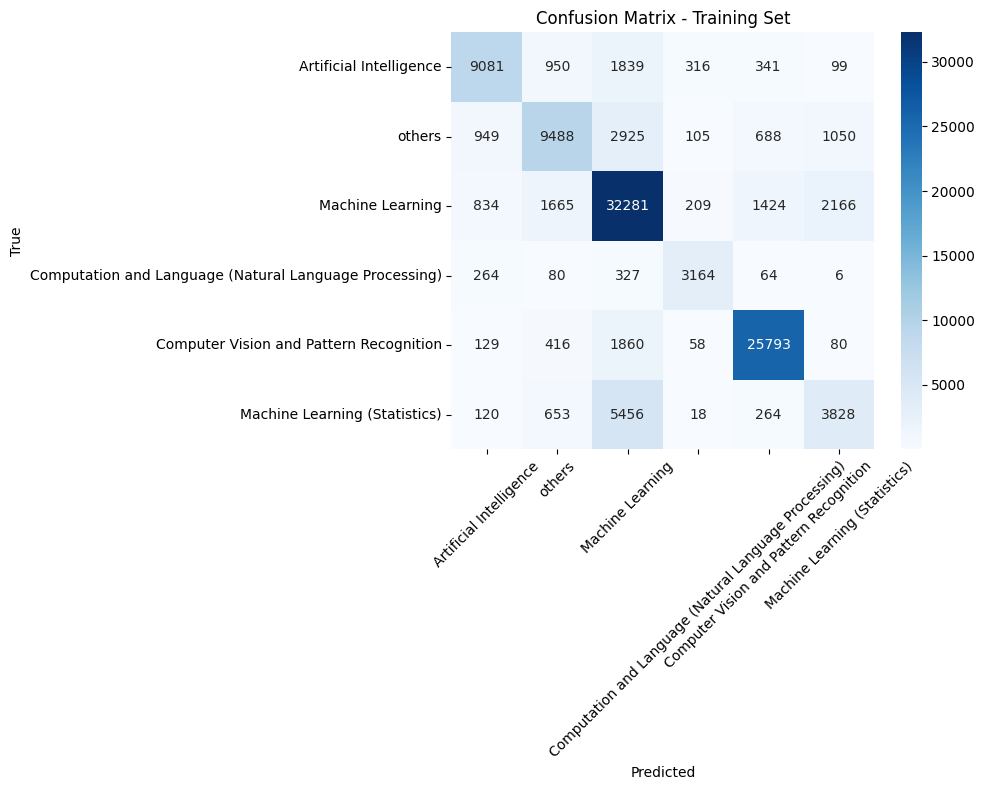


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.80      0.72      0.76     12626
                                                others       0.72      0.62      0.67     15205
                                      Machine Learning       0.72      0.84      0.78     38579
Computation and Language (Natural Language Processing)       0.82      0.81      0.81      3905
               Computer Vision and Pattern Recognition       0.90      0.91      0.91     28336
                         Machine Learning (Statistics)       0.53      0.37      0.44     10339

                                              accuracy                           0.77    108990
                                             macro avg       0.75      0.71      0.73    108990
                                          weighted avg       0.76      0.77      0.76    108990


Results for 

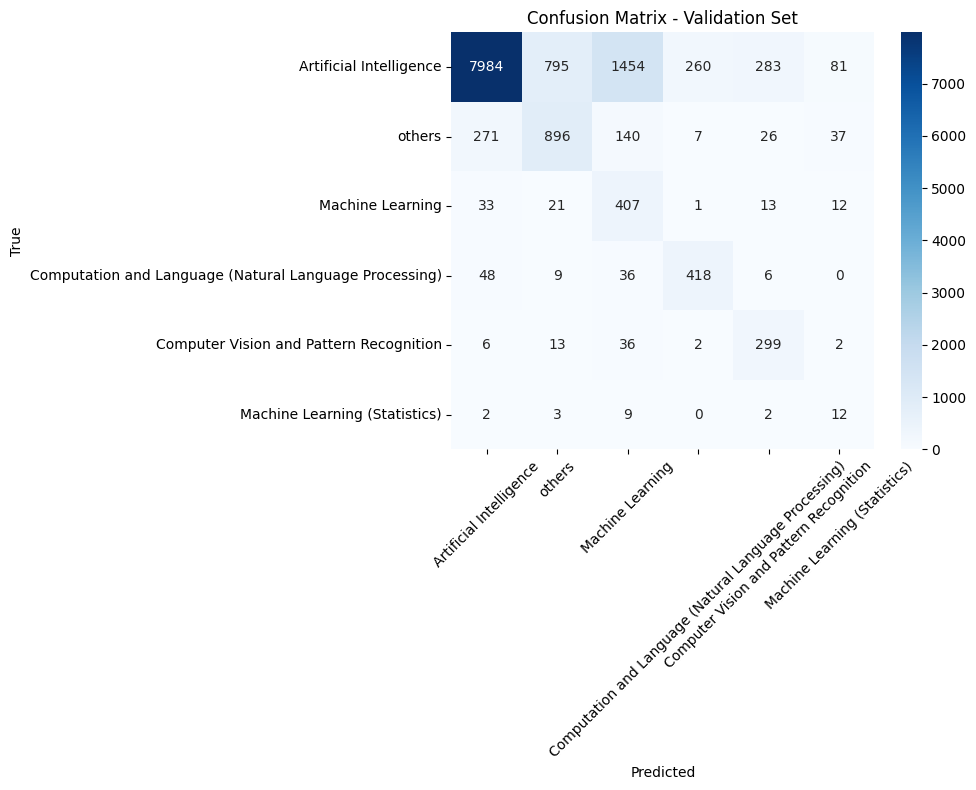


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.96      0.74      0.83     10857
                                                others       0.52      0.65      0.58      1377
                                      Machine Learning       0.20      0.84      0.32       487
Computation and Language (Natural Language Processing)       0.61      0.81      0.69       517
               Computer Vision and Pattern Recognition       0.48      0.84      0.61       358
                         Machine Learning (Statistics)       0.08      0.43      0.14        28

                                              accuracy                           0.74     13624
                                             macro avg       0.47      0.72      0.53     13624
                                          weighted avg       0.86      0.74      0.77     13624


Results for 

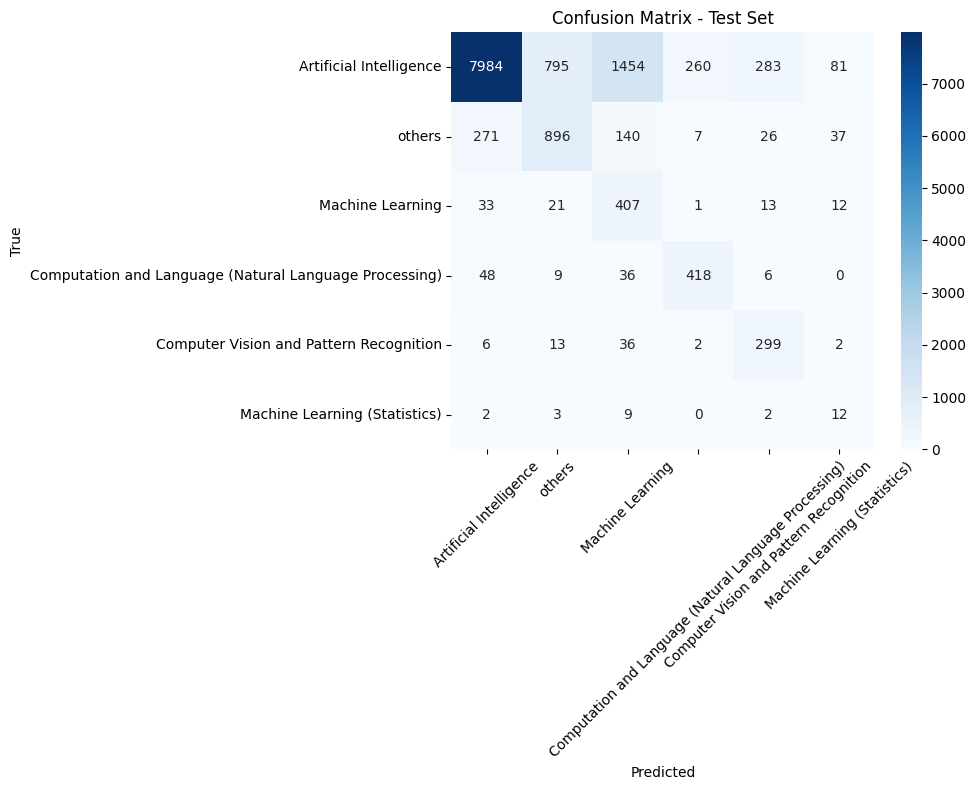


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.96      0.74      0.83     10857
                                                others       0.52      0.65      0.58      1377
                                      Machine Learning       0.20      0.84      0.32       487
Computation and Language (Natural Language Processing)       0.61      0.81      0.69       517
               Computer Vision and Pattern Recognition       0.48      0.84      0.61       358
                         Machine Learning (Statistics)       0.08      0.43      0.14        28

                                              accuracy                           0.74     13624
                                             macro avg       0.47      0.72      0.53     13624
                                          weighted avg       0.86      0.74      0.77     13624



In [209]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Import additional metrics

def evaluate_model(X, Y, split_name=""):
    # Forward pass
    batch_titles = [itot[i.item()] for i in X]
    emb = titles_embbeding(batch_titles, C, pooling_type)
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    probs = F.softmax(logits, dim=1)
    
    # Get predictions
    predictions = torch.argmax(probs, dim=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(Y.numpy(), predictions.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(Y.numpy(), predictions.numpy())
    
    # Print results
    print(f"\nResults for {split_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[itoc[i] for i in range(len(categories))],
                yticklabels=[itoc[i] for i in range(len(categories))])
    plt.title(f'Confusion Matrix - {split_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y.numpy(), predictions.numpy(), 
                              target_names=[itoc[i] for i in range(len(categories))]))
    
    return accuracy, predictions

# Evaluate on all splits
train_acc, train_preds = evaluate_model(Xtr, Ytr, "Training Set")
val_acc, val_preds = evaluate_model(Xdev, Ydev, "Validation Set")
test_acc, test_preds = evaluate_model(Xte, Yte, "Test Set")

### Conclusion : 

We beat the title embedding model without any optimization and with a smaller model. 

Best result so far : 
- ltrain :  0.6415
- dev : 0.7594
- test : 0.7594

with the following hyperparameters :
- emb_dim : 10
- added hidden layer : 1
- hidden layer size : 100
- learning rate : 0.1 and 0.01 in the last 10%
- batch size : 32
- 1M iterations